<a href="https://colab.research.google.com/github/emanuelcatao/CreditCardFraud/blob/main/CreditCard_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Etapas da Resolução do Problema:

1 - **"Análise exploratória dos dados (EDA)":** Vamos primeiro buscar entender o dataset antes de aplicar os algoritmos. O objetivo primeiro desta etapa é tentar visualizar a distribuição das transações legítimas e fraudulentas, bem como qualquer padrão ou tendência incomum que possa ser observada nessa análise.

2- **Pré-processamento de dados:** Depois de termos feito um reconhecimento do terreno em que estamos trabalhando, vamos lidar com quaisquer dados ausentes (se houverem) e dividir o dataset em conjuntos de treinamento e teste.

3 - **Treinamento e avaliação dos modelos:** Aqui é talvez o que nos interesse mais.
- Primeiro, treinar cada um dos três modelos especificados (Naive Bayes, Árvore de Decisão e KNN) com o conjunto de treinamento.
- Em seguida, avaliar cada modelo usando o conjunto de teste e calcular a precisão, para cada modelo.
- Por fim, visualizar as fronteiras de decisão para as features escolhidas. Para isso, precisaremos escolher duas features para visualização, uma vez que fronteiras de decisão são mais facilmente visualizadas em duas dimensões - isso aqui depende também.

4 - **Conclusão**

---

In [4]:
import pandas as pd

# Carregando o dataset
data = pd.read_csv('./dataset/card_transdata.csv')

print('Só a cabecinha 😏\n\n', data.head(), end='\n\n')

'''
  mostra um resumo do dataframe: qtd_linhas,nomes_colunas,
  qtd_nulos_coluna, tipo_dado_coluna, memoria usada
'''
print(data.info())

Só a cabecinha 😏

    distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0

array([[<Axes: title={'center': 'distance_from_home'}>,
        <Axes: title={'center': 'distance_from_last_transaction'}>,
        <Axes: title={'center': 'ratio_to_median_purchase_price'}>],
       [<Axes: title={'center': 'repeat_retailer'}>,
        <Axes: title={'center': 'used_chip'}>,
        <Axes: title={'center': 'used_pin_number'}>],
       [<Axes: title={'center': 'online_order'}>,
        <Axes: title={'center': 'fraud'}>, <Axes: >]], dtype=object)

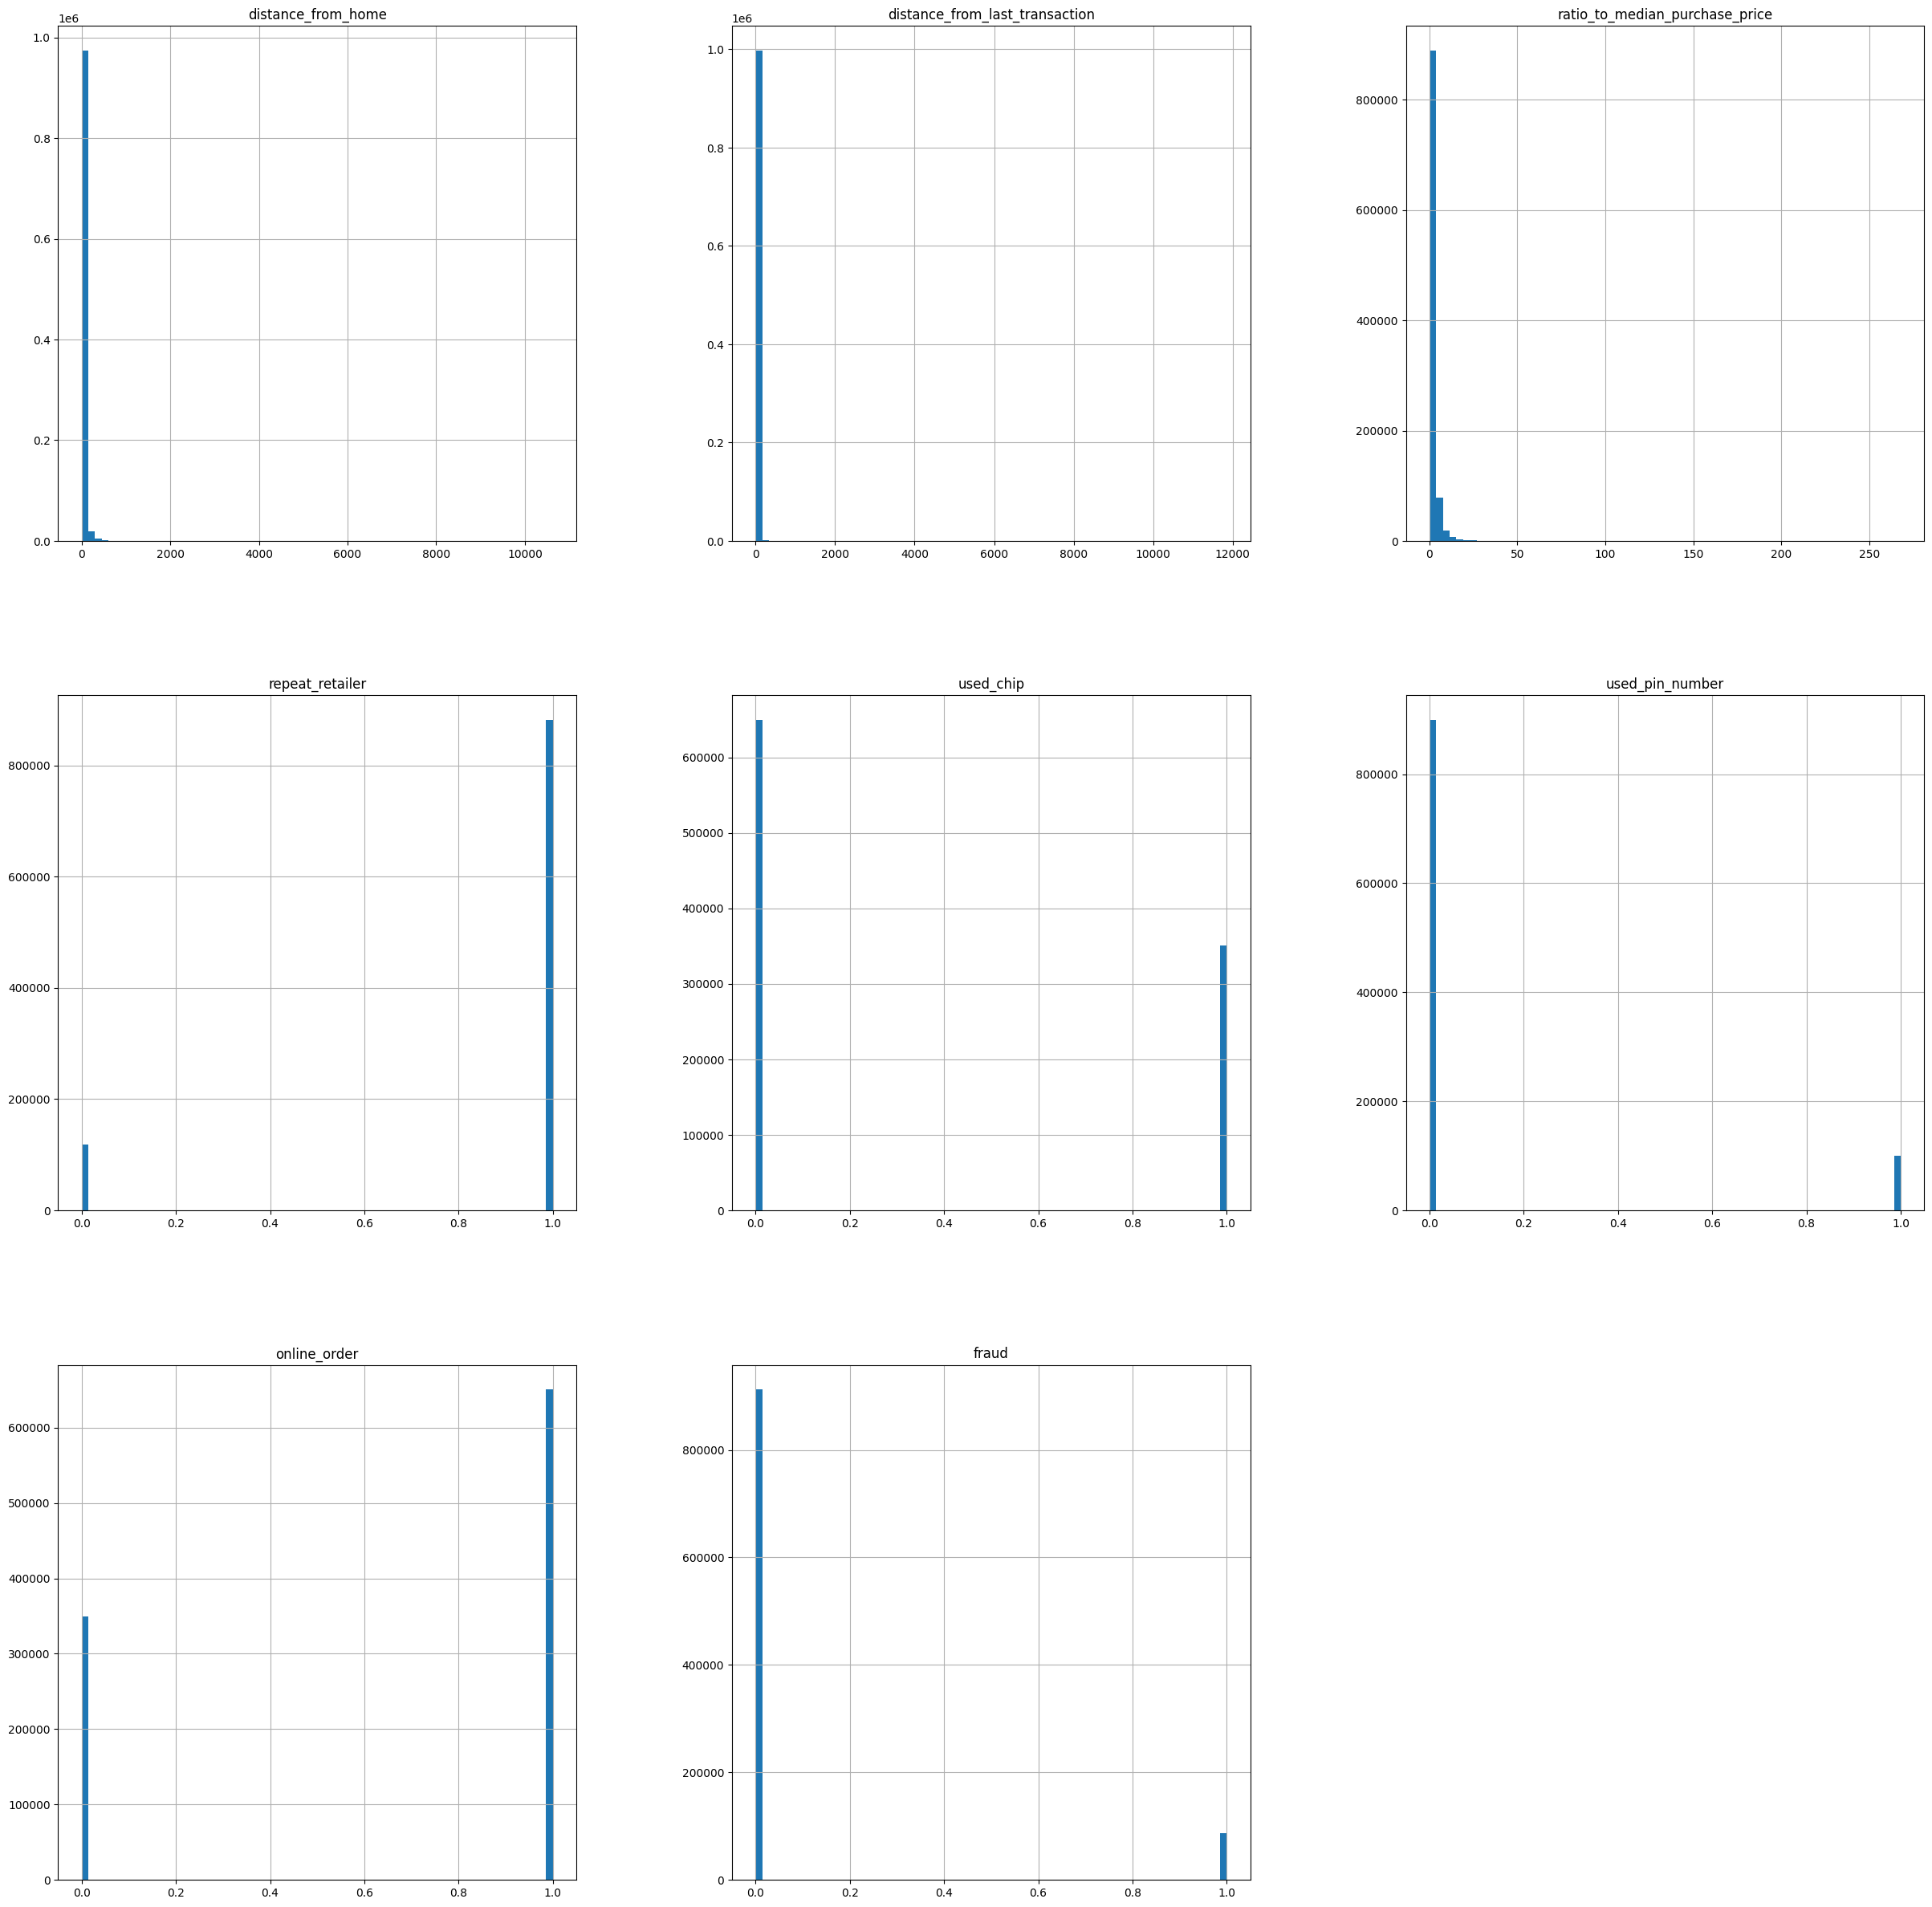

In [5]:
data.hist(bins=70, figsize=(30, 30))

Aqui o dataset foi carregado e temos uma visão geral dos dados:
- São ao todo 1.000.000 entradas, divididas em 8 colunas (sendo uma delas a "coluna alvo", que contém o indicativo de fraude)
- Não há valores ausentes nas colunas (o que indica que já não precisamos da parte do tratamento de dados ausentes. Isso aqui só aconteceu por que o conjunto de dados é muito bem definido e se trata um problema para estudo).
- Aparentemente cinco dessas colunas, a saber *repeat_retailer*, *used_chip*, *used_pin_number*, *online_order*, e *fraud*, parecem ter dados binários.



In [6]:
print(data.describe())

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%   

**distance_from_home**: A média da distância entre a transação atual e o domicílio do titular do cartão é de cerca de 26.63, com um desvio padrão de 65.39. A distância máxima é bem da alta (10632.72) em relação à média (possíveis outliers ou transações muito distantes da residência do titular - internacionais por exemplo). Nessa aqui o banco já bloqueia lul

**distance_from_last_transaction**: A média é de aproximadamente 5.04, mas o desvio padrão é de 25.84, o que é alto. Novamente, vemos que o valor máximo é extremamente alto (11851.10) em comparação com a média, indicando possíveis outliers. (Essa aqui parece ser uma feature importante para identificar fraude).

**ratio_to_median_purchase_price**: A média da proporção do valor da transação atual e a mediana dos valores das transações do cartão é de aproximadamente 1.82. O valor máximo é muito alto (267.80), ou seja, em algumas transações o valor foi muito superior à mediana dos valores das transações. (não significa absolutamente nada)

**repeat_retailer, used_chip, used_pin_number, online_order**: Estes são campos binários. 88% das transações foram feitas com varejistas repetidos, 35% usaram chip, 10% usaram número PIN e 65% foram pedidos online. (sozinhos assim, não significam absolutamente nada)


Para nos ajudar a entender ainda melhor a que deveremos estar atentos nesse dataset, veremos rapidamente os números relacionados aos dados relacionados a fraudes e aos dados relacionados a não fraudes.

In [7]:
fraud = data[data["fraud"] == 1]["fraud"].count()
n_fraud = data[data["fraud"] == 0]["fraud"].count()
print("Número de transações fraudulentas:", fraud)
print("Número de transações não fraudulentas:", n_fraud)
print("Percentual de fraude:", fraud / (fraud + n_fraud) * 100, "%")

Número de transações fraudulentas: 87403
Número de transações não fraudulentas: 912597
Percentual de fraude: 8.7403 %


#### Dataset desbalanceado:

- Transações não-fraudulentas: 912.597 (aproximadamente 91,3%)
- Transações fraudulentas: 87.403 (aproximadamente 8,7%)

Como fraudes são eventos relativamente raros em comparação com transações legítimas, isso era de se imaginar (tem até demais aqui). É importante levar isso em consideração ao treinar e avaliar os modelos, pois a acurácia sozinha pode ser enganosa.

Para tentar lidar com isso vamos fazer uso de um oversampling com SMOTE (vamos criar exemplos sintéticos de fraude), pq é mais simples de ser aplicado.

In [8]:
X = data.drop('fraud', axis=1).values
y = data['fraud'].values

In [9]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(random_state=39)

# Cria exemplos sintéticos e equilibra as classes
X_resampled, y_resampled = smote_sampler.fit_resample(X, y)

# Novo dataframe com os dados reamostrados
resampled_df = pd.DataFrame(X_resampled, columns=["distance_from_home", "distance_from_last_transaction",
                   "ratio_to_median_purchase_price", "repeat_retailer", "used_chip",
                   "used_pin_number", "online_order"])

# Exibir o DataFrame
resampled_df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,57.877857,0.311140,1.945940,1.0,1.000000,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.000000,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.000000,0.0,1.0
3,2.247564,5.600044,0.362663,1.0,1.000000,0.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.000000,0.0,1.0
...,...,...,...,...,...,...,...
1825189,0.865098,1.341068,4.173964,0.0,1.000000,0.0,1.0
1825190,4.803252,0.744443,6.650998,1.0,1.000000,0.0,1.0
1825191,12.536102,119.006991,4.094842,1.0,0.835731,0.0,1.0
1825192,389.245617,3.480952,0.922567,1.0,0.000000,0.0,1.0


Perceba que o número de dados nesse dataframe é quase que o dobro do original

In [10]:
print(resampled_df.shape)
print(resampled_df.info())
print(resampled_df.describe())

(1825194, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825194 entries, 0 to 1825193
Data columns (total 7 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   distance_from_home              float64
 1   distance_from_last_transaction  float64
 2   ratio_to_median_purchase_price  float64
 3   repeat_retailer                 float64
 4   used_chip                       float64
 5   used_pin_number                 float64
 6   online_order                    float64
dtypes: float64(7)
memory usage: 97.5 MB
None
       distance_from_home  distance_from_last_transaction  \
count        1.825194e+06                    1.825194e+06   
mean         4.442516e+01                    8.458492e+00   
std          1.018351e+02                    3.750252e+01   
min          4.874385e-03                    1.182816e-04   
25%          4.142911e+00                    3.112290e-01   
50%          1.173429e+01                    1.050549e+00 

Vamos apenas checar a correlação e então partir para a resolução da coisa.


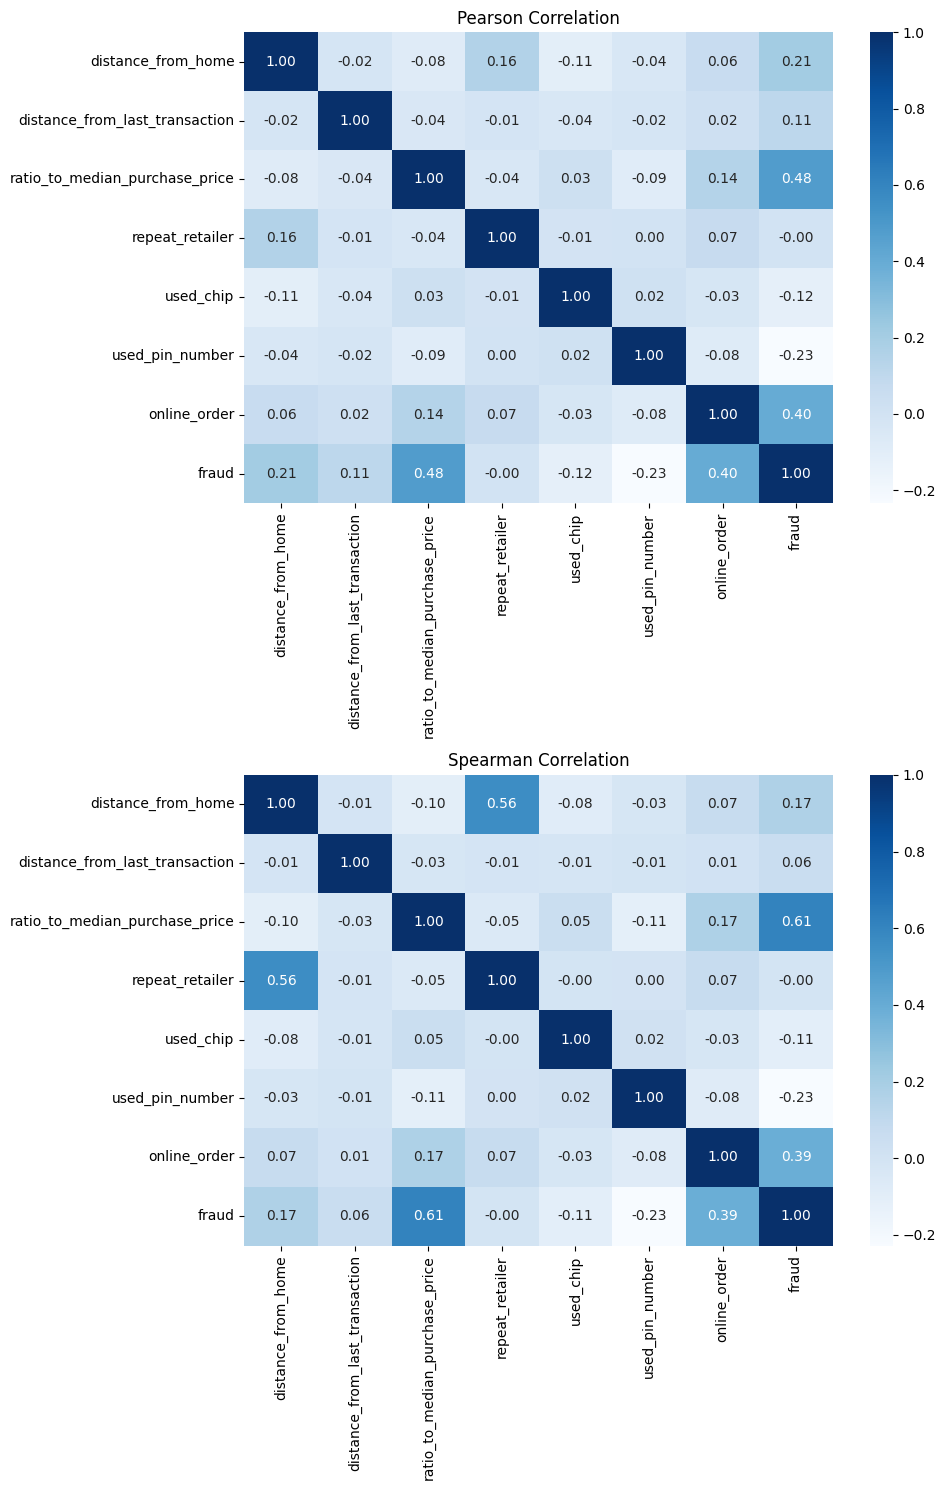

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#Insiro novamente a tag fraud para poder visualizar na correlação
resampled_df["fraud"] = y_resampled
dt = resampled_df

corr = dt.corr()
spearman_corr = dt.corr(method='spearman')

fig, ax = plt.subplots(nrows=2, figsize=(10, 15))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt=".2f", cmap="Blues", ax=ax[0])
ax[0].set_title('Pearson Correlation')

sns.heatmap(spearman_corr, xticklabels=spearman_corr.columns, yticklabels=spearman_corr.columns, annot=True, fmt=".2f", cmap="Blues", ax=ax[1])
ax[1].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

Essa correlação já pode nos servir de indicador para a escolha das features. Perceba como, principalmente na correlação de Spearman `ratio_to_media_purchase_price` e `online_order`se destacam das demais na comparação direta com fraud.

In [12]:
from sklearn.model_selection import train_test_split

features = ["distance_from_home", "distance_from_last_transaction",
                   "ratio_to_median_purchase_price", "repeat_retailer", "used_chip",
                   "used_pin_number", "online_order"]

X_train, X_test, y_train, y_test = train_test_split(dt[features], dt.fraud, test_size=0.2, random_state=42, stratify= dt.fraud)

X_train.shape, X_test.shape

((1460155, 7), (365039, 7))

Usei o stratify=dt.fraud para que a proporção de classes de fraude seja mantida tanto nos conjuntos de treinamento quanto de teste.

Como temos KNN para analisar também, vamos normalizar já que esse algoritmo é sensível à escala das features. Daí:

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.35816025, -0.17399779, -0.7028602 , ..., -0.6705862 ,
        -0.24507034,  0.52631185],
       [-0.24737542, -0.19295958,  0.12552708, ...,  1.52463261,
        -0.24507034,  0.52631185],
       [-0.41847205, -0.16600105,  0.04988139, ..., -0.6705862 ,
        -0.24507034, -1.92451481],
       ...,
       [ 0.05784149,  0.55816587,  1.27160724, ...,  1.29191483,
        -0.24507034,  0.52631185],
       [-0.34003675,  1.27169987, -0.67323605, ..., -0.6705862 ,
        -0.24507034,  0.52631185],
       [-0.41615102, -0.05076961,  0.32844009, ..., -0.6705862 ,
        -0.24507034,  0.52631185]])

# Modelo de Naive Bayes com Distribuição de Gauss

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Inicializar e treinar o modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
nb_predictions = nb_model.predict(X_test_scaled)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("AUC:", roc_auc_score(y_test, nb_predictions))
print(classification_report(y_test, nb_predictions))

Naive Bayes Results:
Accuracy: 0.783305345456239
AUC: 0.7833058385749738
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.74    182520
         1.0       0.71      0.96      0.82    182519

    accuracy                           0.78    365039
   macro avg       0.83      0.78      0.78    365039
weighted avg       0.83      0.78      0.78    365039



**Accuracy** (Precisão global) é de 78.33%. Isso significa que 78.33% das transações foram classificadas corretamente.

**AUC** (Area Under the Curve) é de aproximadamente 0.789, um AUC de 0.5 indica um classificador não melhor do que um sorteio aleatório, enquanto um AUC de 1.0 indica um classificador perfeito. Nesse caso ele é um meia bomba.
Ao observar a precisão, recall e F1-score para a classe minoritária (fraudes), vemos que o modelo tem espaço para melhorias.

#### No fim:

  - Precisão bem alta para "não fraude", mas seu recall é baixo (sabe dar pitaco, mas na hora do vamo ver é aquelas). Isso significa que ele é cauteloso ao classificar transações como "não fraude", mas acaba perdendo muitas "não fraudes" verdadeiras.
  - Para "fraude", o modelo tem um recall muito alto, o que é bom, pois é importante identificar a maioria das fraudes. Contudo, a precisão é menor, indicando que algumas transações legítimas são erroneamente classificadas como fraudulentas.
  - Globalmente, o modelo tem desempenho decente, mas dependendo do contexto e do custo associado a falsos positivos e falsos negativos, pode ser necessário ajustá-lo ou considerar outros modelos.

# Modelo Árvore de Decisão

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Inicializar e treinar o modelo Árvore de Decisão
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
dt_predictions = dt_model.predict(X_test_scaled)

print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("AUC:", roc_auc_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))


Decision Tree Results:
Accuracy: 0.9999726056667918
AUC: 0.9999726056667916
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182520
         1.0       1.00      1.00      1.00    182519

    accuracy                           1.00    365039
   macro avg       1.00      1.00      1.00    365039
weighted avg       1.00      1.00      1.00    365039



**Accuracy:** quase perfeito.

**AUC** quase perfeito.

A precisão, recall e F1-score são praticamente 1, indicando classificações quase perfeitas.

É de se imaginar um desempenho suspeito, já que detecção de fraudes é um problema bastante complexo (overfitting?). O modelo pode ter memorizado o conjunto de treinamento e pode não ter um desempenho tão bom em novos dados. Como não temos novos dados para teste, podemos partir para uma validação cruzada para ter mais certeza. (Isso num cenário de mundo real, muito provavelmente isso aqui tá certo nesse cenário controlado, mas é isso)

# Modelo KNN:

Aqui uma heurística comum é pegar a raiz do número de amostras, mas seria muito custoso ao menos para nosso caso (a raiz é algo próximo de 1400), então vamos de usar um valor arbitrário de vizinhos (k = 31), tomando o cuidado de ser impar para não dar conflito, uma vez que são targets binários e escolhendo um número primo pq sim.

Poderíamos fazer uma validação cruzada testando diferentes valores para k, mas novamente agilidade.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

knn_model = KNeighborsClassifier(n_neighbors=31)
knn_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
knn_predictions = knn_model.predict(X_test_scaled)

print("\nKNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("AUC:", roc_auc_score(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))



KNN Results:
Accuracy: 0.9981645796750485
AUC: 0.9981645837274619
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182520
         1.0       1.00      1.00      1.00    182519

    accuracy                           1.00    365039
   macro avg       1.00      1.00      1.00    365039
weighted avg       1.00      1.00      1.00    365039



Os resultados também são quase perfeitos, ou seja, o problema que pode estar ocorrendo na árvore de decisão pode estar se repetindo aqui.

Em um cenário real deveríamos fazer uma série de validações e até mesmo possíveis inserções de novos dados para realmente certificar a acurácia do modelo.

Sigamos para a escolha das features.

Como discutido na parte das correlações, `ratio_to_median_purchase_price` e `online_order` já têm mostrado potêncial de features que devamos observar. Vamos agora somente buscar o feature_importances_ para melhorar a nossa escolha.

In [17]:
feature_importances = dt_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                          Feature  Importance
2  ratio_to_median_purchase_price    0.510088
0              distance_from_home    0.261536
1  distance_from_last_transaction    0.102519
6                    online_order    0.055820
4                       used_chip    0.031641
5                 used_pin_number    0.019775
3                 repeat_retailer    0.018622


Ok, vaja que nossa ideia inicial é bem o que estávamos imaginando, mas aqui o feature_importances dá destaque também para o distance_from_home. Na correlação ele aparece como o terceiro na fila de destaques.

Vamos ficar com o que haviamos imaginado inicialmente.

In [18]:
X_train_selected = X_train_scaled[:, [2, 6]] #As tags das features aqui
X_test_selected = X_test_scaled[:, [2, 6]]

#Treinando novamente para as features selecionadas
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_selected, y_train)

knn_model = KNeighborsClassifier(n_neighbors=31)
knn_model.fit(X_train_selected, y_train)

nb_predictions = naive_bayes_model.predict(X_test_selected)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("AUC:", roc_auc_score(y_test, nb_predictions))
print(classification_report(y_test, nb_predictions))


dt_model.fit(X_train_selected, y_train)
dt_predictions = dt_model.predict(X_test_selected)

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("AUC:", roc_auc_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))

knn_predictions = knn_model.predict(X_test_selected)

print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("AUC:", roc_auc_score(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))

Naive Bayes Results:
Accuracy: 0.822890156942135
AUC: 0.8228899019830954
              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84    182520
         1.0       0.90      0.73      0.80    182519

    accuracy                           0.82    365039
   macro avg       0.83      0.82      0.82    365039
weighted avg       0.83      0.82      0.82    365039

Decision Tree Results:
Accuracy: 0.8012239788077439
AUC: 0.8012239378392143
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80    182520
         1.0       0.81      0.79      0.80    182519

    accuracy                           0.80    365039
   macro avg       0.80      0.80      0.80    365039
weighted avg       0.80      0.80      0.80    365039

KNN Results:
Accuracy: 0.850106426984514
AUC: 0.8501061063838616
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87    182520
         1.0       0.96

Perceba com o Naive Bayes mudou de cara com as features, agora é mais preciso, mas perdeu em recall.

Para a Decision Tree mudou muita coisa também, pudera, ele considera o online_order como fator mediano.

Pro KNN deu uma diferenciada legal do que vimos anteriormente, ainda é bastante preciso, mas tem um recall mais baixo.

Aqui entra a análise se o objetivo é capturar todas as possíveis fraudes, mesmo que algumas transações legítimas sejam rotuladas como fraudulentas, então o recall é uma métrica mais relevante. Mas se o objetivo é evitar falsos positivos, nada melhor que uma boa precisão.

Nosso f1_score está até que mais ou menos, então temos um certo equilíbrio.

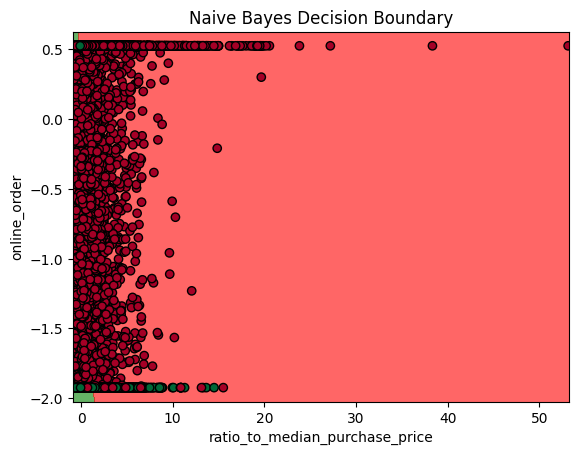

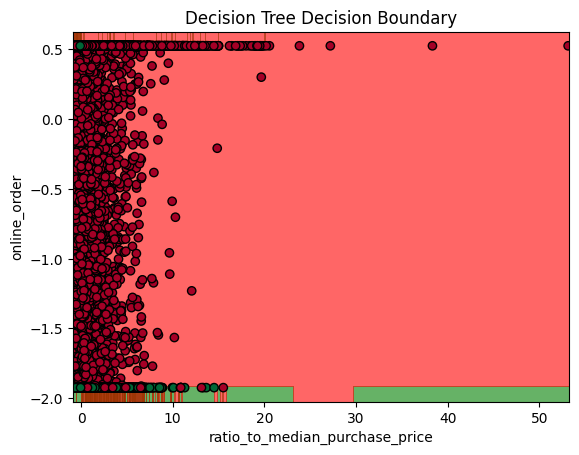

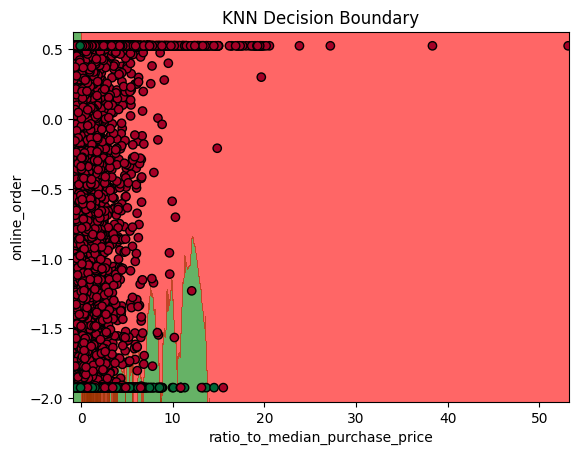

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    try:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    except AttributeError:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    colors = ['green', 'red']
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=colors, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlGn_r, marker='o')
    plt.xlabel('ratio_to_median_purchase_price')
    plt.ylabel('online_order')
    plt.title(title)
    plt.show()

plot_decision_boundary(naive_bayes_model, X_test_selected, y_test, 'Naive Bayes Decision Boundary')
plot_decision_boundary(dt_model, X_test_selected, y_test, 'Decision Tree Decision Boundary')
plot_decision_boundary(knn_model, X_test_selected, y_test, 'KNN Decision Boundary')

